Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Michael Fridkin"
COLLABORATORS = "Hamid S & Em Baez Abreu"

---

## Analysis Code

This is the notebook you should submit with your analysis code.

In [1]:
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


In [2]:
df_essay = pd.read_csv('A3CleanedEssayData.csv')
df_essay.columns


Index(['id', 'essay_prompt', 'authorship', 'class_type', 'grade_letter',
       'gptzero_label', 'gptzero_ai_percent', 'contentdetector_label',
       'contentdetector_ai_percent', 'sapling_fake_percent',
       'copyleaks_ai_percent'],
      dtype='object')

In [3]:
df_essay['authorship'].value_counts()

authorship
Entirely written by me                            115
AI-generated                                      108
Partly written by me, partly by AI                 52
Written by me, but grammar was corrected by AI     34
Name: count, dtype: int64

In [4]:
keep_mask = df_essay['authorship'].isin(["Entirely written by me", "AI-generated"])

df_clean = df_essay[keep_mask].copy()

authorship_mapping = { "Entirely written by me": 0, "AI-generated": 1, }

df_clean['y_true'] = df_clean['authorship'].map(authorship_mapping)

print(df_clean['authorship'].value_counts())
print("\nPrevalence of AI essays:", df_clean['y_true'].mean())
df_clean[['authorship', 'y_true']].head()


authorship
Entirely written by me    115
AI-generated              108
Name: count, dtype: int64

Prevalence of AI essays: 0.484304932735426


,authorship,y_true
0,Entirely written by me,0
1,Entirely written by me,0
3,Entirely written by me,0
5,AI-generated,1
6,Entirely written by me,0


In [5]:
detector_score_cols = {"gptzero": "gptzero_ai_percent", 
                       "contentdetector": "contentdetector_ai_percent",
                       "sapling": "sapling_fake_percent",
                       "copyleaks": "copyleaks_ai_percent",
                      }

for det_name, col in detector_score_cols.items():
    s = pd.to_numeric(df_clean[col], errors='coerce')
    df_clean[f"{det_name}_prob_ai"] = s / 100.0

df_clean[[c for c in df_clean.columns if c.endswith("_prob_ai")]].head()

,gptzero_prob_ai,contentdetector_prob_ai,sapling_prob_ai,copyleaks_prob_ai
0,0.0,0.25,0.001,0.0
1,0.0,0.00,0.000,0.0
3,0.0,0.48,0.003,0.0
5,0.0,0.00,0.778,0.0
6,0.0,0.60,0.105,0.0


### Evaluation Metrics ###

In [6]:
import numpy as np

In [7]:
def confusion_counts(y_true, y_pred):

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tn = np.sum((y_true == 0) & (y_pred == 0))

    return {"TP": tp, "FP": fp, "FN": fn, "TN": tn}

In [8]:
def accuracy(cm):
    tp, fp, fn, tn = cm["TP"], cm["FP"], cm["FN"], cm["TN"]
    total = tp + fp + fn + tn
    return (tp + tn) / total if total > 0 else np.nan

In [9]:
def ppv(cm):
    tp, fp = cm["TP"], cm["FP"]
    return tp / (tp + fp) if (tp + fp) > 0 else np.nan

In [10]:
def npv(cm):
    fn, tn = cm["FN"], cm["TN"]
    return tn / (tn + fn) if (tn + fn) > 0 else np.nan

In [11]:
def tpr(cm):
    tp, fn = cm["TP"], cm["FN"]
    return tp / (tp + fn) if (tp + fn) > 0 else np.nan

In [12]:
def tnr(cm):
    fp, tn = cm["FP"], cm["TN"]
    return tn / (tn + fp) if (tn + fp) > 0 else np.nan

In [13]:
def all_metrics(cm):
    return{
        "Accuracy": accuracy(cm),
        "PPV": ppv(cm),
        "NPV": npv(cm),
        "TPR": tpr(cm),
        "TNR": tnr(cm),
        "TP": cm["TP"],
        "FP": cm["FP"],
        "FN": cm["FN"],
        "TN": cm["TN"],
    }

In [14]:
def evaluate_detector_at_threshold(y_true, prob_ai, threshold = 0.5):
    y_pred = (prob_ai >= threshold).astype(int)
    cm = confusion_counts(y_true, y_pred)
    return all_metrics(cm)

In [15]:
results_default = {}
for det_name in ["gptzero", "contentdetector", "sapling", "copyleaks"]:
    prob_col = f"{det_name}_prob_ai"
    metrics = evaluate_detector_at_threshold(df_clean['y_true'], df_clean[prob_col], threshold = 0.5)
    results_default[det_name] = metrics

results_default_df = pd.DataFrame(results_default).T
results_default_df

,Accuracy,PPV,NPV,TPR,TNR,TP,FP,FN,TN
gptzero,0.896861,0.929293,0.870968,0.851852,0.939130,92.0,7.0,16.0,108.0
contentdetector,0.681614,0.676190,0.686441,0.657407,0.704348,71.0,34.0,37.0,81.0
sapling,0.784753,0.708333,0.924051,0.944444,0.634783,102.0,42.0,6.0,73.0
copyleaks,0.892377,0.875000,0.909910,0.907407,0.878261,98.0,14.0,10.0,101.0


In [16]:
def threshold_sweep(y_true, prob_ai, thresholds):
    rows = []
    for th in thresholds:
        y_pred = (prob_ai >= th).astype(int)
        cm = confusion_counts(y_true, y_pred)
        m = all_metrics(cm)
        m["threshold"] = th
        rows.append(m)
    return pd.DataFrame(rows)

In [17]:
thresholds_dict = {
    "gptzero": [0.5, 0.87],
    "contentdetector": [0.5, 0.75],
    "sapling": [0.5, 0.87],
    "copyleaks": [0.5, 0.85],
}

threshold_results = []
for det_name, th_list in thresholds_dict.items():
    prob_col = f"{det_name}_prob_ai"
    df_sweep = threshold_sweep(df_clean['y_true'], df_clean[prob_col], th_list)
    df_sweep["detector"] = det_name
    threshold_results.append(df_sweep)

all_threshold_results = pd.concat(threshold_results, ignore_index=True)
all_threshold_results

,Accuracy,PPV,NPV,TPR,TNR,TP,FP,FN,TN,threshold,detector
0,0.896861,0.929293,0.870968,0.851852,0.939130,92,7,16,108,0.50,gptzero
1,0.878924,0.965517,0.823529,0.777778,0.973913,84,3,24,112,0.87,gptzero
2,0.681614,0.676190,0.686441,0.657407,0.704348,71,34,37,81,0.50,contentdetector
3,0.650224,0.788462,0.608187,0.379630,0.904348,41,11,67,104,0.75,contentdetector
4,0.784753,0.708333,0.924051,0.944444,0.634783,102,42,6,73,0.50,sapling
5,0.843049,0.806723,0.884615,0.888889,0.800000,96,23,12,92,0.87,sapling
6,0.892377,0.875000,0.909910,0.907407,0.878261,98,14,10,101,0.50,copyleaks
7,0.887892,0.895238,0.881356,0.870370,0.904348,94,11,14,104,0.85,copyleaks


In [18]:
for det_name in ["gptzero", "contentdetector", "sapling", "copyleaks"]:
    print(f"\n=== {det_name} ===")
    sub = all_threshold_results[all_threshold_results["detector"] == det_name]
    display(sub[["threshold", "Accuracy", "PPV", "NPV", "TPR", "TNR", "TP", "FP", "FN", "TN"]])


=== gptzero ===


,threshold,Accuracy,PPV,NPV,TPR,TNR,TP,FP,FN,TN
0,0.50,0.896861,0.929293,0.870968,0.851852,0.939130,92,7,16,108
1,0.87,0.878924,0.965517,0.823529,0.777778,0.973913,84,3,24,112



=== contentdetector ===


,threshold,Accuracy,PPV,NPV,TPR,TNR,TP,FP,FN,TN
2,0.50,0.681614,0.676190,0.686441,0.657407,0.704348,71,34,37,81
3,0.75,0.650224,0.788462,0.608187,0.379630,0.904348,41,11,67,104



=== sapling ===


,threshold,Accuracy,PPV,NPV,TPR,TNR,TP,FP,FN,TN
4,0.50,0.784753,0.708333,0.924051,0.944444,0.634783,102,42,6,73
5,0.87,0.843049,0.806723,0.884615,0.888889,0.800000,96,23,12,92



=== copyleaks ===


,threshold,Accuracy,PPV,NPV,TPR,TNR,TP,FP,FN,TN
6,0.50,0.892377,0.875000,0.909910,0.907407,0.878261,98,14,10,101
7,0.85,0.887892,0.895238,0.881356,0.870370,0.904348,94,11,14,104


### GPTZERO change with prevalence ###

In [19]:
det_name = "gptzero"
metrics = results_default[det_name]
tpr_val = metrics["TPR"]
tnr_val = metrics["TNR"]
tpr_val, tnr_val

(0.8518518518518519, 0.9391304347826087)

In [20]:
def ppv_given_prevalence(tpr_val, tnr_val, prevalence):
    pi = prevalence
    return (tpr_val * pi) / (tpr_val * pi + (1 - tnr_val) * (1 - pi))

def npv_given_prevalence(tpr_val, tnr_val, prevalence):
    pi = prevalence
    return (tnr_val * (1 - pi)) / (tnr_val * (1 - pi) + (1 - tpr_val) * pi)

In [21]:
prevalences = np.linspace(0.01, 0.99, 20)
rows = []
for pi in prevalences:
    rows.append({
        "prevalence": pi, 
        "PPV": ppv_given_prevalence(tpr_val, tnr_val, pi),
        "NPV": npv_given_prevalence(tpr_val, tnr_val, pi),
    })

df_prev = pd.DataFrame(rows)
df_prev

,prevalence,PPV,NPV
0,0.010000,0.123853,0.998409
1,0.061579,0.478713,0.989755
2,0.113158,0.641021,0.980269
3,0.164737,0.734053,0.969826
4,0.216316,0.794360,0.958274
5,0.267895,0.836628,0.945426
6,0.319474,0.867897,0.931050
7,0.371053,0.891965,0.914858
8,0.422632,0.911064,0.896481
9,0.474211,0.926589,0.875446


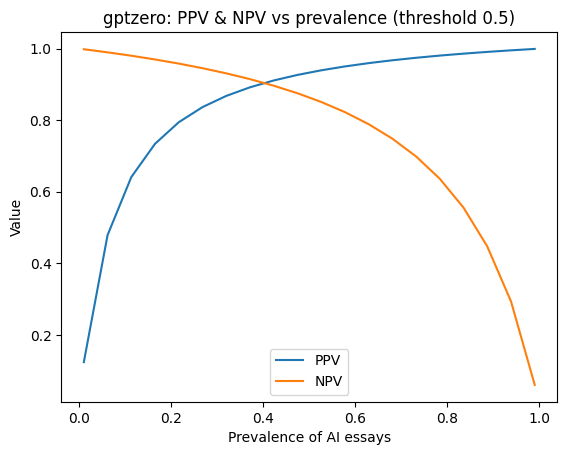

In [22]:
plt.figure()
plt.plot(df_prev["prevalence"], df_prev["PPV"], label="PPV")
plt.plot(df_prev["prevalence"], df_prev["NPV"], label="NPV")
plt.xlabel("Prevalence of AI essays")
plt.ylabel("Value")
plt.title(f"{det_name}: PPV & NPV vs prevalence (threshold 0.5)")
plt.legend()
plt.show()

In [26]:
display(df_essay[df_essay["authorship"] == "Partly written by me, partly by AI"])

,id,essay_prompt,authorship,class_type,grade_letter,gptzero_label,gptzero_ai_percent,contentdetector_label,contentdetector_ai_percent,sapling_fake_percent,copyleaks_ai_percent
2,22620,****,"Partly written by me, partly by AI",Other,A,Human,0.0,May Have AI,95.0,90.0,93.0
9,19036,Active‚ÄØvs.‚ÄØPassive Allocation Decision Mo...,"Partly written by me, partly by AI",Other,NaN,Human,0.0,Likely Human,50.0,78.9,0.0
12,25711,"Answer the question ""What is Religion?"" Rememb...","Partly written by me, partly by AI",Other,A,Human,0.0,May Have AI,63.0,0.7,0.0
16,22409,"Before answering your questions, download the ...","Partly written by me, partly by AI",Ethics,A,Human,0.0,Likely Human,34.0,99.0,89.1
31,25121,Dichotomies Preventing Reaction.,"Partly written by me, partly by AI",English,NaN,Human,0.0,Likely Human with AI,0.0,0.1,0.0
35,14967,Does the use of Artificial Intelligence (AI) b...,"Partly written by me, partly by AI",Ethics,B,Human,0.0,Likely Human,54.0,7.3,0.0
39,1244,"For this week's essay, please focus only on an...","Partly written by me, partly by AI",History,A,Human,0.0,Likely Human,28.0,99.1,0.0
47,1149,How did the American Revolution and the events...,"Partly written by me, partly by AI",History,A,Mixed,0.0,May Have AI,66.0,100.0,0.0
55,16491,"In Chapter I of Russell's Analysis of Mind, Ru...","Partly written by me, partly by AI",Technology,B,Human,0.0,Likely Human,15.3,15.3,0.0
59,28261,In what ways did the depiction of colonialism ...,"Partly written by me, partly by AI",History,A,Human,0.0,Likely Human,0.0,1.9,0.0


In [27]:
df_essay[df_essay["authorship"] == "Partly written by me, partly by AI"].count()

id                            52
essay_prompt                  52
authorship                    52
class_type                    52
grade_letter                  38
gptzero_label                 52
gptzero_ai_percent            52
contentdetector_label         52
contentdetector_ai_percent    52
sapling_fake_percent          52
copyleaks_ai_percent          52
dtype: int64

In [29]:
df_essay[(df_essay["authorship"] == "Partly written by me, partly by AI") & (df_essay["gptzero_label"] == "Mixed")].count()

id                            14
essay_prompt                  14
authorship                    14
class_type                    14
grade_letter                  11
gptzero_label                 14
gptzero_ai_percent            14
contentdetector_label         14
contentdetector_ai_percent    14
sapling_fake_percent          14
copyleaks_ai_percent          14
dtype: int64

In [30]:
df_essay[(df_essay["authorship"] == "Partly written by me, partly by AI") & (df_essay["gptzero_label"] == "Human")].count()

id                            22
essay_prompt                  22
authorship                    22
class_type                    22
grade_letter                  17
gptzero_label                 22
gptzero_ai_percent            22
contentdetector_label         22
contentdetector_ai_percent    22
sapling_fake_percent          22
copyleaks_ai_percent          22
dtype: int64

In [31]:
df_essay[(df_essay["authorship"] == "Partly written by me, partly by AI") & (df_essay["gptzero_label"] == "AI")].count()

id                            16
essay_prompt                  16
authorship                    16
class_type                    16
grade_letter                  10
gptzero_label                 16
gptzero_ai_percent            16
contentdetector_label         16
contentdetector_ai_percent    16
sapling_fake_percent          16
copyleaks_ai_percent          16
dtype: int64

In [25]:
df_essay.head()

,id,essay_prompt,authorship,class_type,grade_letter,gptzero_label,gptzero_ai_percent,contentdetector_label,contentdetector_ai_percent,sapling_fake_percent,copyleaks_ai_percent
0,28798,‚ÄúAnalyze how authors use deception as a lite...,Entirely written by me,English,B,Human,0.0,Likely Human,25.0,0.1,0.0
1,11722,"""What are dark ghettos""",Entirely written by me,Ethics,A,Human,0.0,Likely Human,0.0,0.0,0.0
2,22620,****,"Partly written by me, partly by AI",Other,A,Human,0.0,May Have AI,95.0,90.0,93.0
3,28920,1.\tUsing Iran and North Korea‚Äôs decision to...,Entirely written by me,History,B,Human,0.0,Likely Human,48.0,0.3,0.0
4,1110,1. Based on Jeremy Brecher's account of the 18...,"Written by me, but grammar was corrected by AI",History,A,Human,0.0,Likely Human,0.0,28.8,0.0
